In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [45]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [46]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [47]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [48]:
df_us.shape

(29, 24)

In [49]:
df_states.shape

(1541, 25)

In [50]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [51]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [52]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-03-28,56,118234,617470,65712,8725.0,16729.0,2174.0,2314.0,54.0,...,1965,16729.0,801416,735704,735704,435.0,3011.0,90250.0,18821.0,109071.0
3,2020-03-29,56,139061,692290,65549,9922.0,19730.0,2456.0,2642.0,59.0,...,2428,19730.0,896900,831351,831351,463.0,3001.0,74820.0,20827.0,95647.0
2,2020-03-30,56,160530,784324,65382,12147.0,22303.0,2982.0,3177.0,259.0,...,2939,22303.0,1010236,944854,944854,511.0,2573.0,92034.0,21469.0,113503.0
1,2020-03-31,56,184770,864201,59529,14236.0,26660.0,3402.0,3644.0,69.0,...,3746,26660.0,1108500,1048971,1048971,807.0,4357.0,79877.0,24240.0,104117.0
0,2020-04-01,56,210770,939190,59687,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209647,1149960,1149960,954.0,4482.0,74989.0,26000.0,100989.0


In [53]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-02,NE,246.0,3978.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4235,4224,4224,31,1.0,0.0,503.0,36.0,539.0
31,2020-04-02,ND,159.0,4821.0,NaN,NaN,28.0,NaN,NaN,NaN,...,28.0,4980,4980,4980,38,0.0,5.0,470.0,17.0,487.0
30,2020-04-02,NC,1857.0,26822.0,NaN,184.0,204.0,NaN,NaN,NaN,...,204.0,28679,28679,28679,37,6.0,0.0,2163.0,273.0,2436.0
28,2020-04-02,MS,1177.0,4753.0,NaN,NaN,360.0,NaN,NaN,NaN,...,360.0,5930,5930,5930,28,4.0,28.0,1041.0,104.0,1145.0
0,2020-04-02,AK,143.0,4879.0,NaN,NaN,9.0,NaN,NaN,NaN,...,9.0,5022,5022,5022,2,0.0,0.0,409.0,10.0,419.0


In [54]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per million
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e6)

# Calculate hospitalized per million
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e6)

# Calculate deaths per million
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e6)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per million people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e6)

In [55]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResultsIncrease,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate
1464,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN
1465,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0
1466,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN
1467,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN
1468,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN


In [56]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,positiveIncrease,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate
count,1469.000000,1364.000000,445.000000,90.000000,378.000000,27.000000,50.000000,25.000000,35.000000,102.000000,...,1417.000000,1417.000000,1469.000000,1.469000e+03,1451.000000,1469.000000,378.000000,812.000000,1359.000000,1364.000000
mean,1023.438393,5544.979472,1360.119101,1016.644444,506.206349,822.444444,399.640000,26.240000,116.200000,349.558824,...,168.491884,893.266761,29.515997,6.538389e+06,429.648088,116.676533,48.133098,4.096994,0.125438,1160.376246
std,5289.344611,12810.182292,8359.256819,2722.063755,2038.181151,1058.136582,748.983686,37.037459,158.303655,1209.568531,...,703.132814,2139.760976,16.301587,7.368210e+06,1601.448507,325.999205,108.745985,9.567061,0.142951,1763.056937
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,4.000000,2.000000,...,-38.000000,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,97.000000,4.000000,31.000000,22.000000,14.000000,14.750000,6.000000,9.500000,19.000000,...,2.000000,14.000000,16.000000,1.805832e+06,54.955978,1.990826,9.515188,0.310207,0.044579,32.305691
50%,73.000000,916.000000,21.000000,59.500000,78.000000,410.000000,62.500000,17.000000,32.000000,34.500000,...,15.000000,115.000000,29.000000,4.468402e+06,109.860468,20.998813,21.827421,1.198597,0.083333,308.189603
75%,420.000000,4853.500000,102.000000,235.500000,254.000000,1436.500000,250.500000,31.000000,178.000000,64.000000,...,83.000000,760.000000,42.000000,7.535591e+06,229.511156,113.103385,42.431649,3.758116,0.152543,1691.879912
max,92381.000000,146584.000000,64400.000000,13383.000000,20817.000000,3396.000000,3022.000000,193.000000,507.000000,7434.000000,...,9298.000000,23649.000000,72.000000,3.955704e+07,11490.119540,4727.254734,1065.232697,121.429466,0.891705,12228.146777


## California

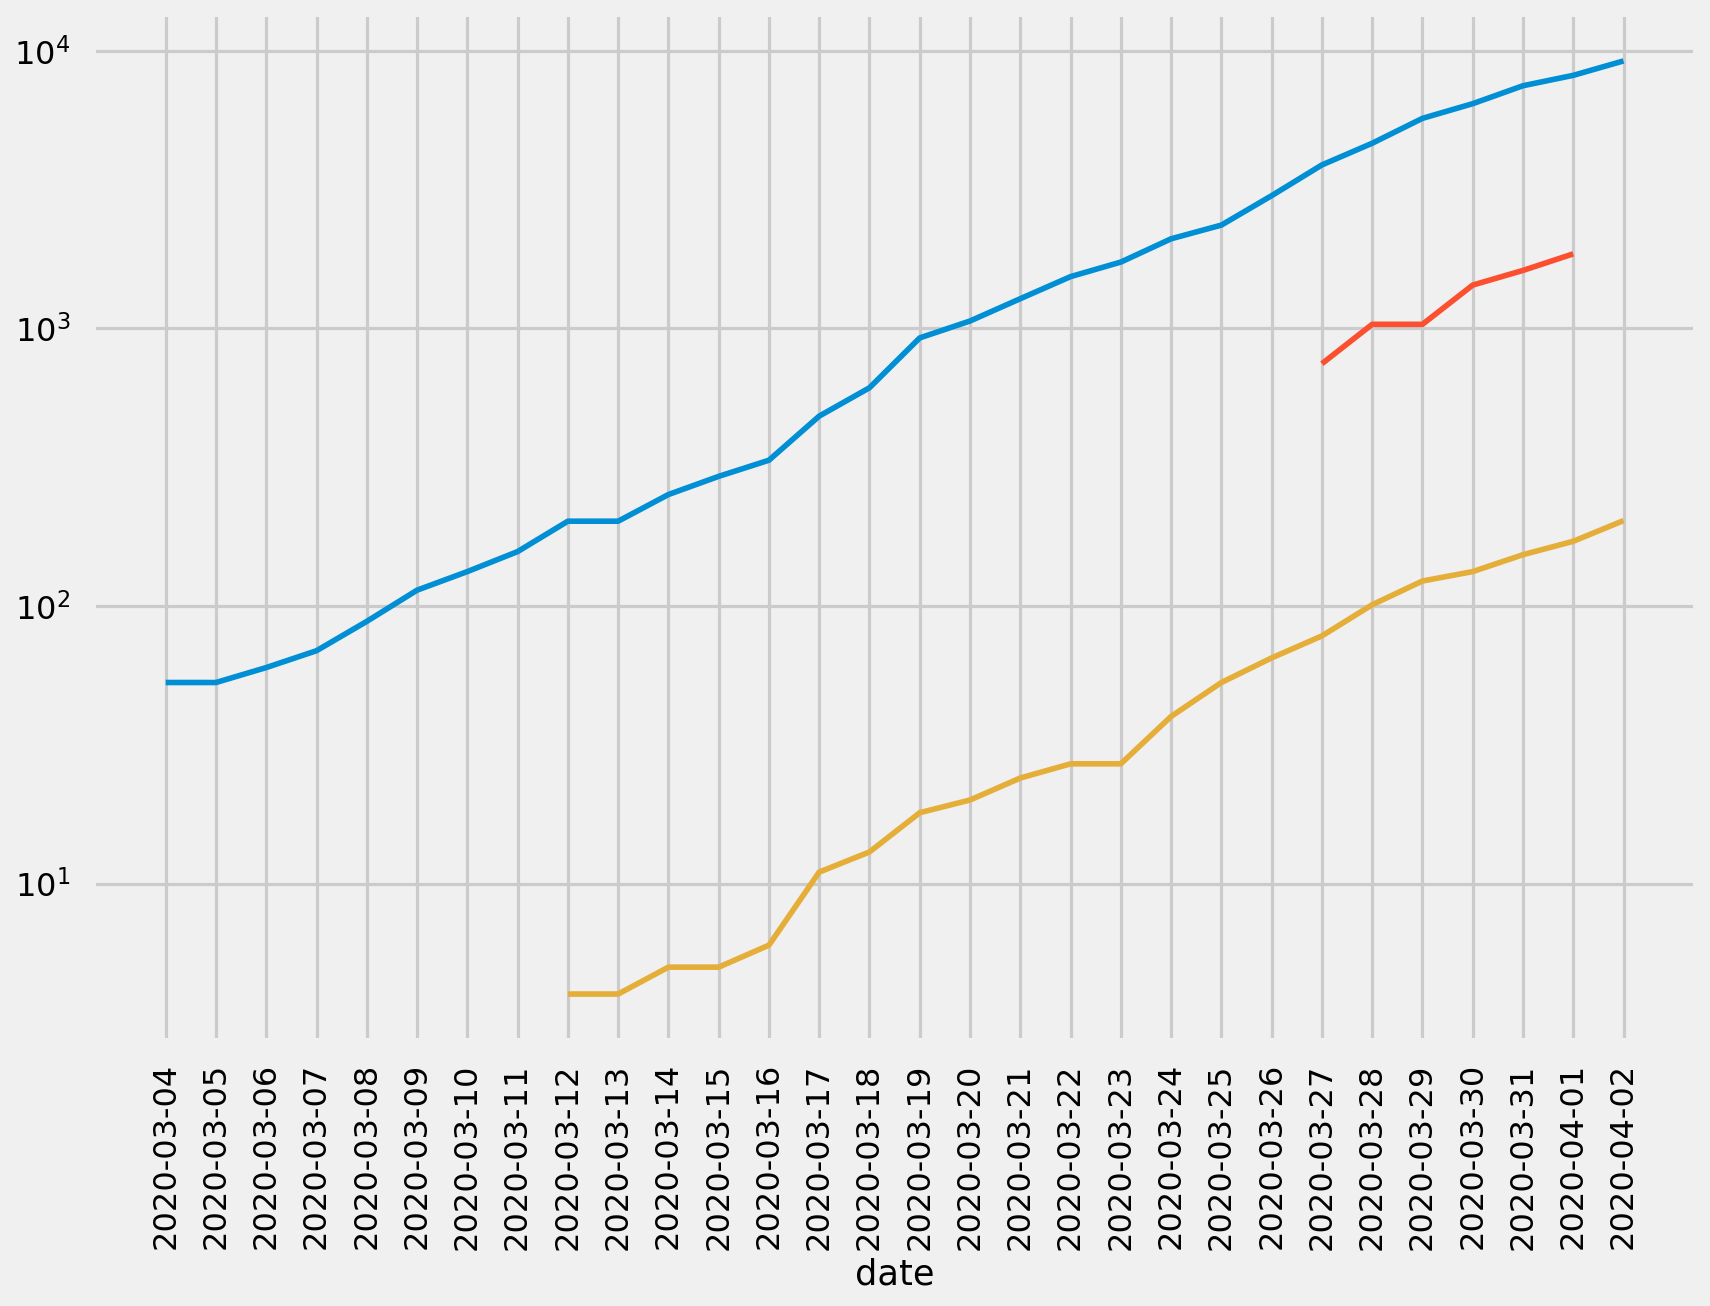

In [57]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

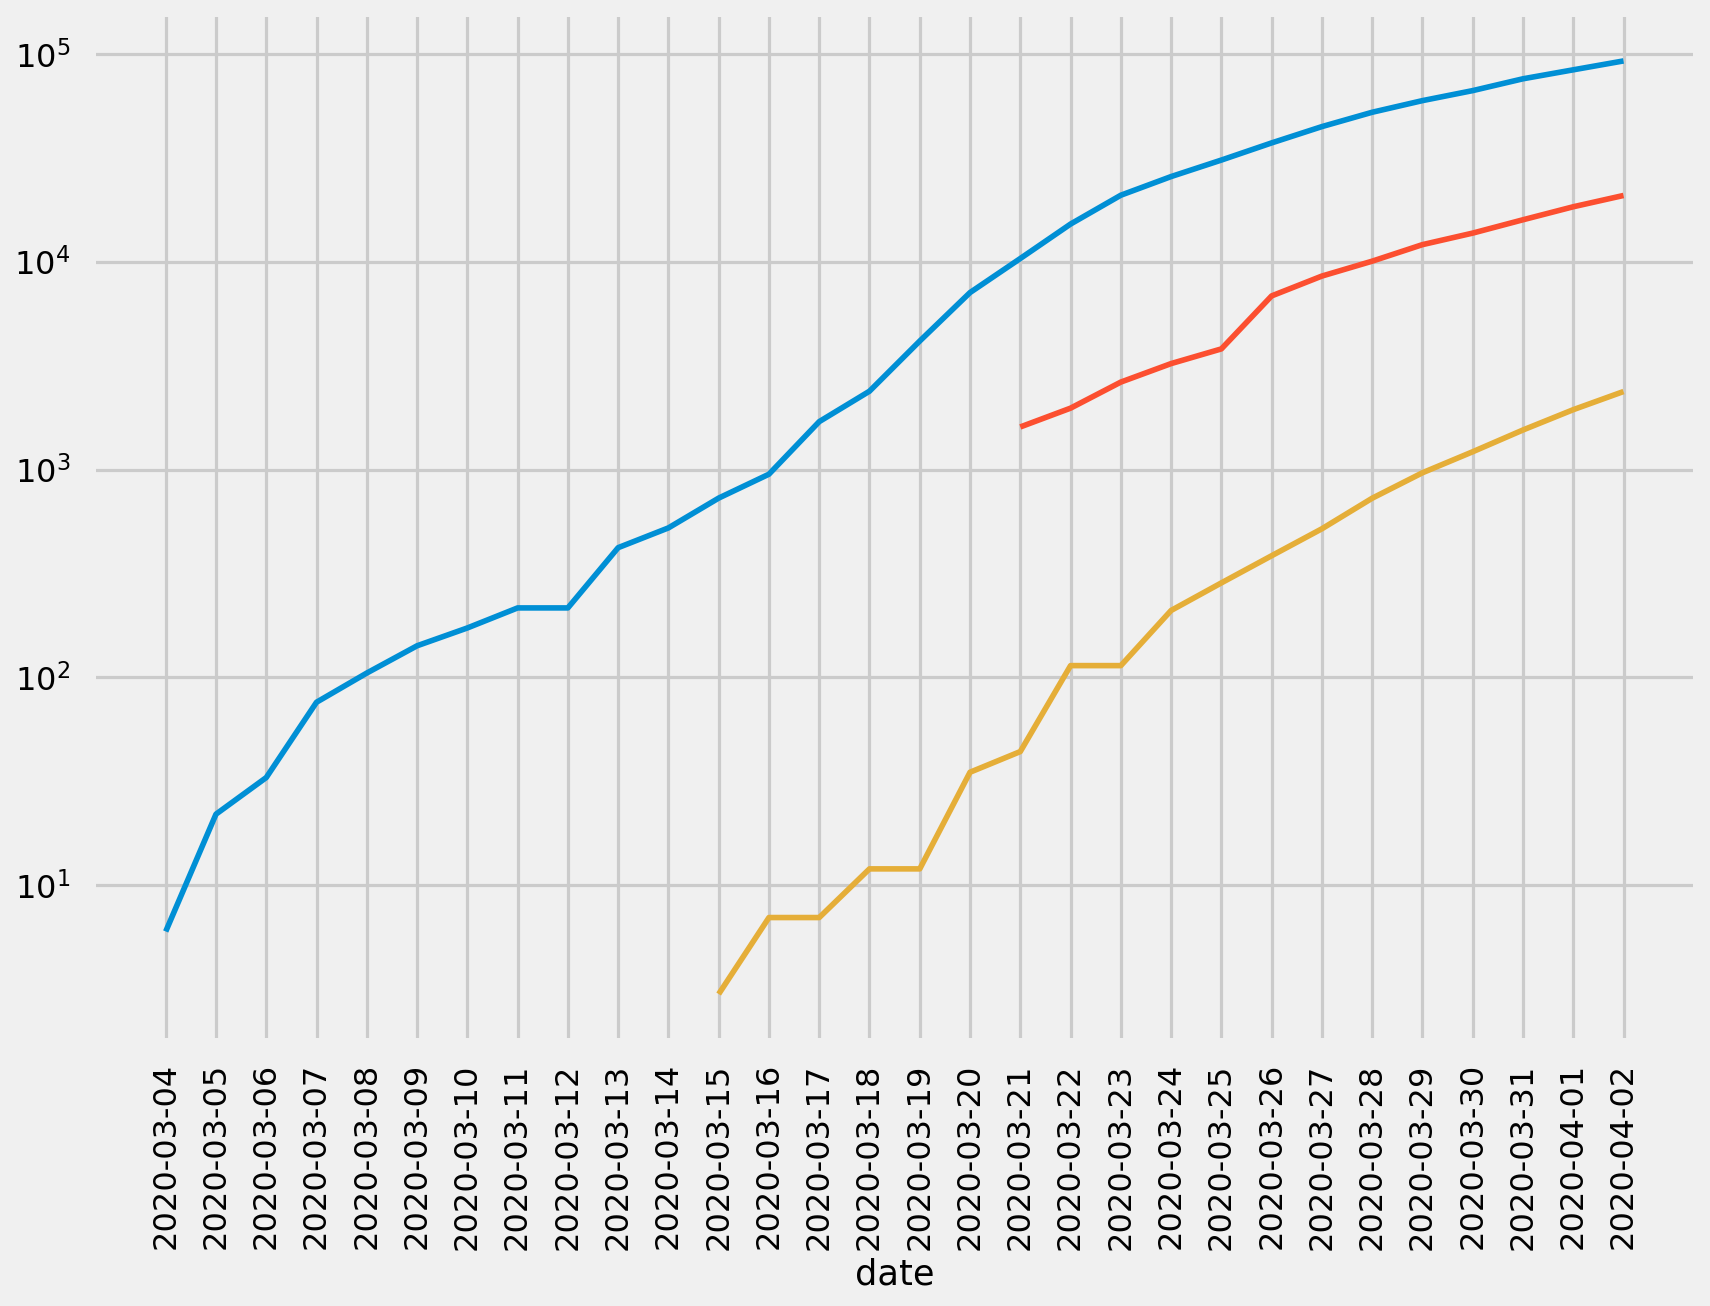

In [58]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [59]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'WA', 'CA', 'GA', 'IL', 'MA', 'FL']

In [60]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
965,NY,2373.0
879,NJ,537.0
625,MI,417.0
512,LA,310.0
1354,WA,247.0
113,CA,203.0
286,GA,163.0
398,IL,157.0
539,MA,154.0
256,FL,128.0


In [61]:
# Deaths per million people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
965,NY,121.429466
512,LA,66.523919
879,NJ,60.279373
625,MI,41.717041
1354,WA,32.777787
172,CT,31.349147
1326,VT,27.143585
539,MA,22.311892
199,DC,17.082945
286,GA,15.495070


# Deaths

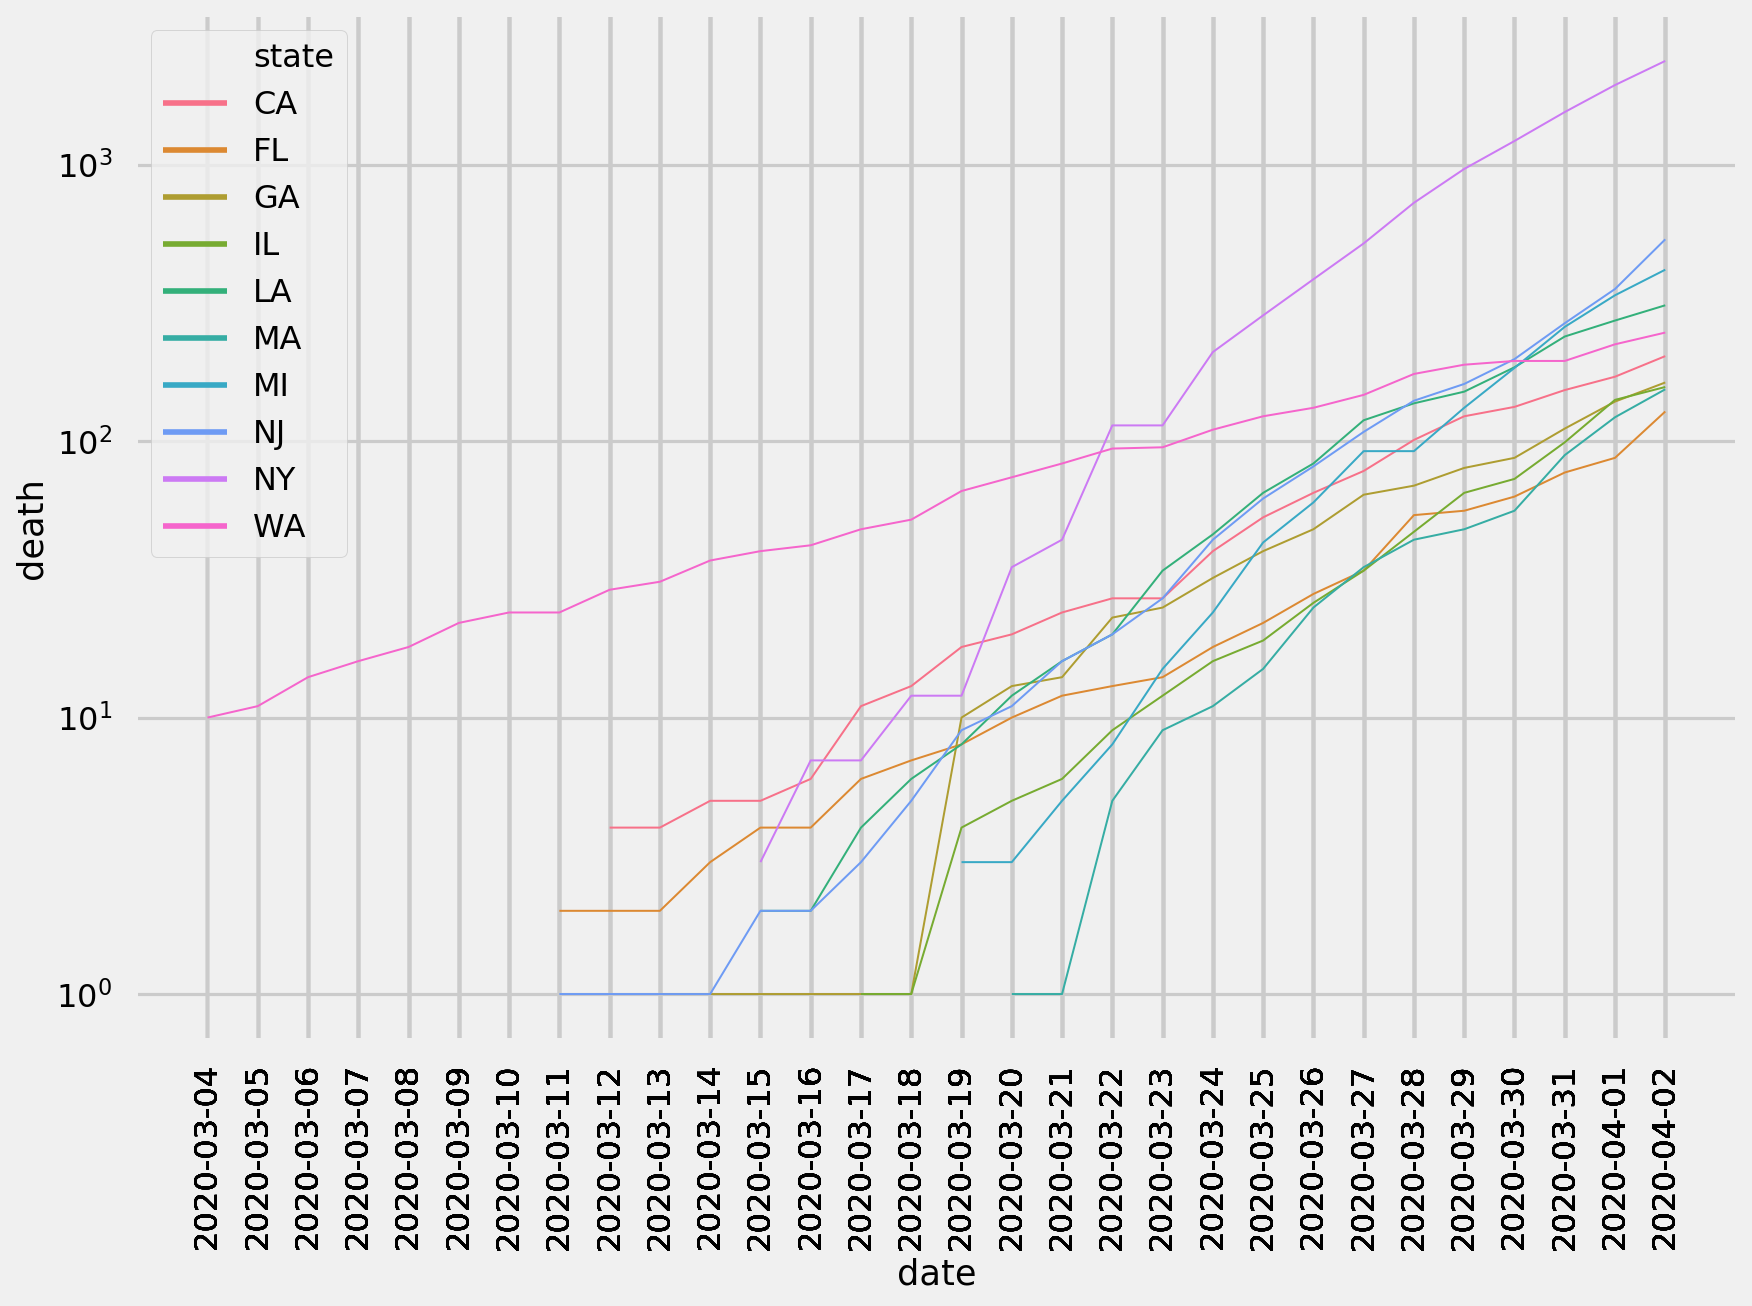

In [62]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per Million People

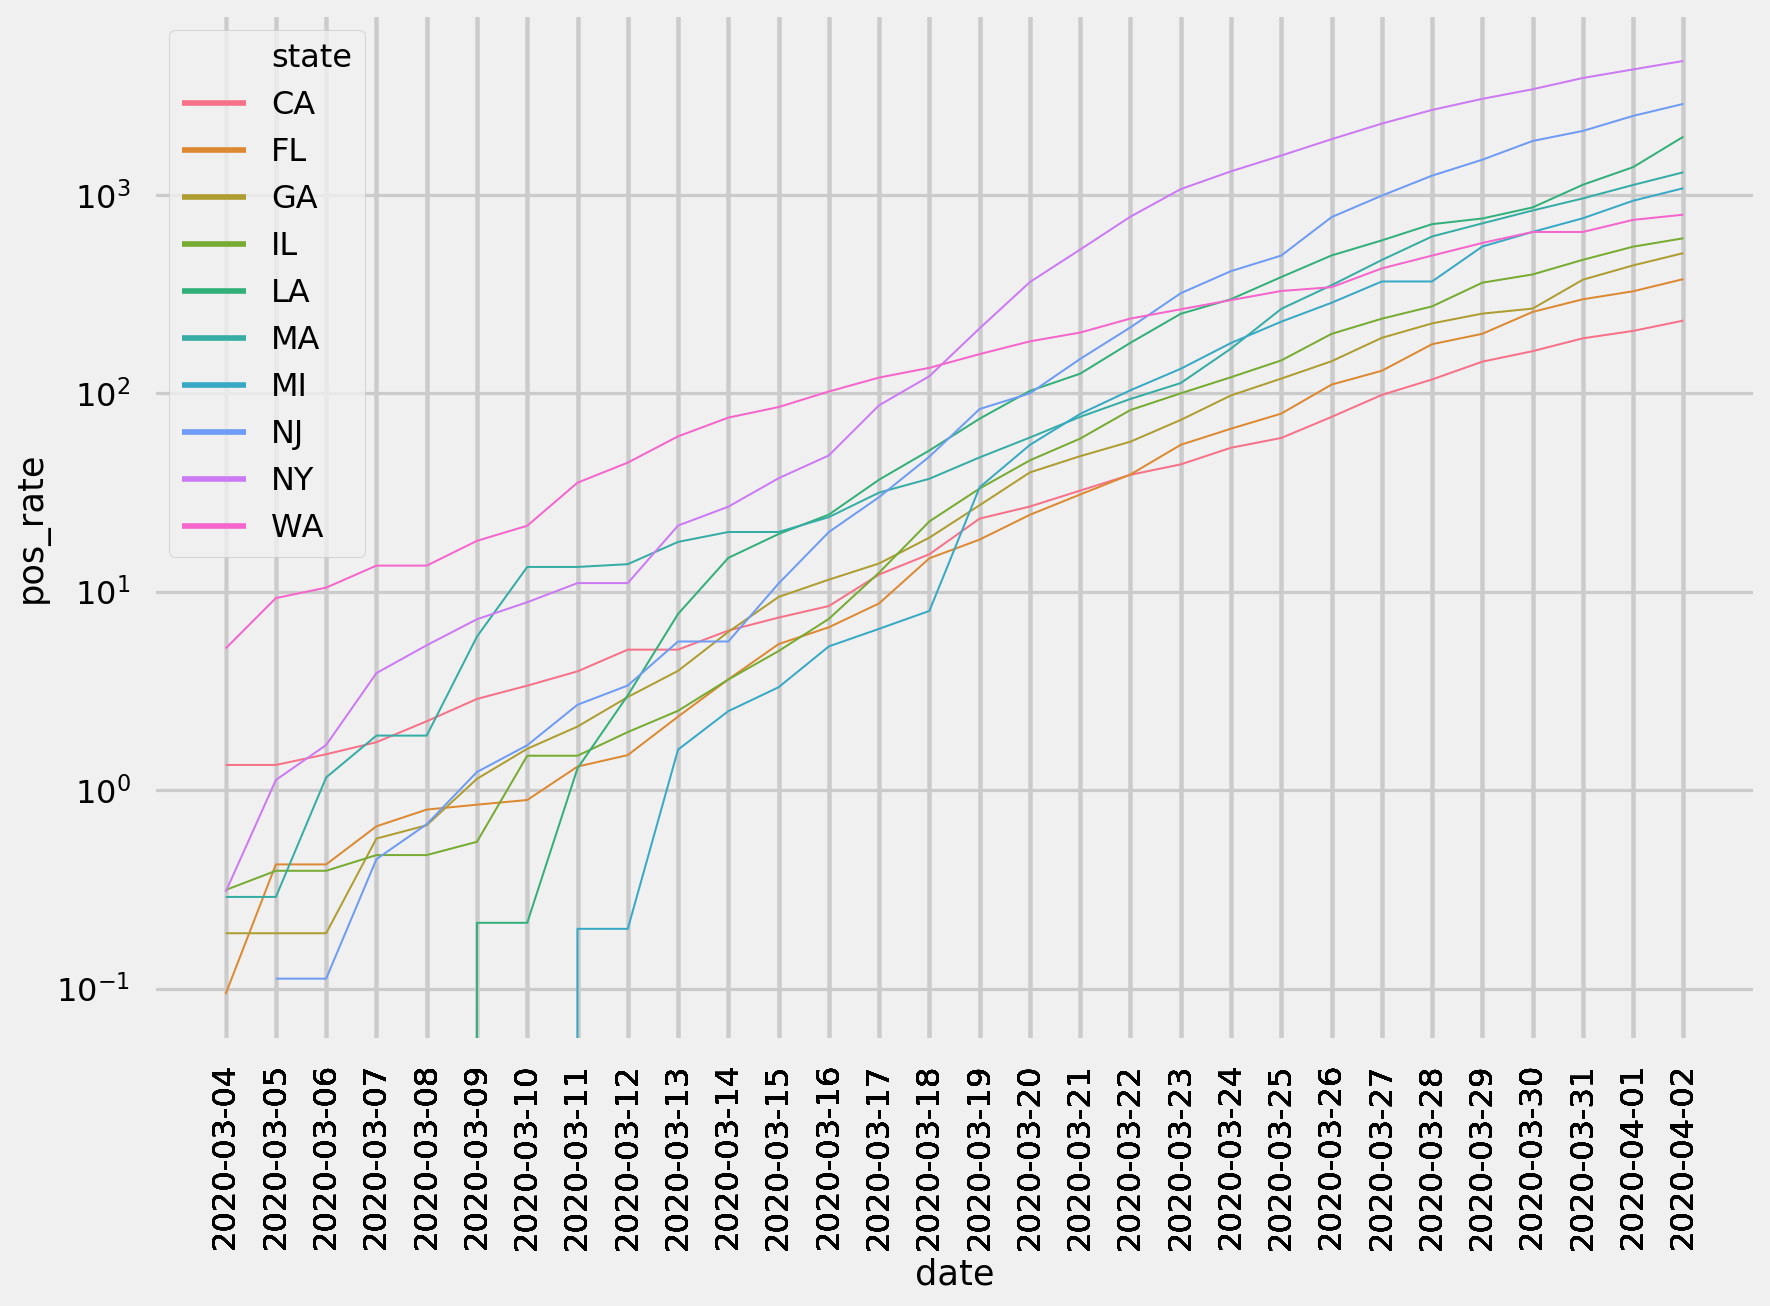

In [63]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Hospitalized Per Million People

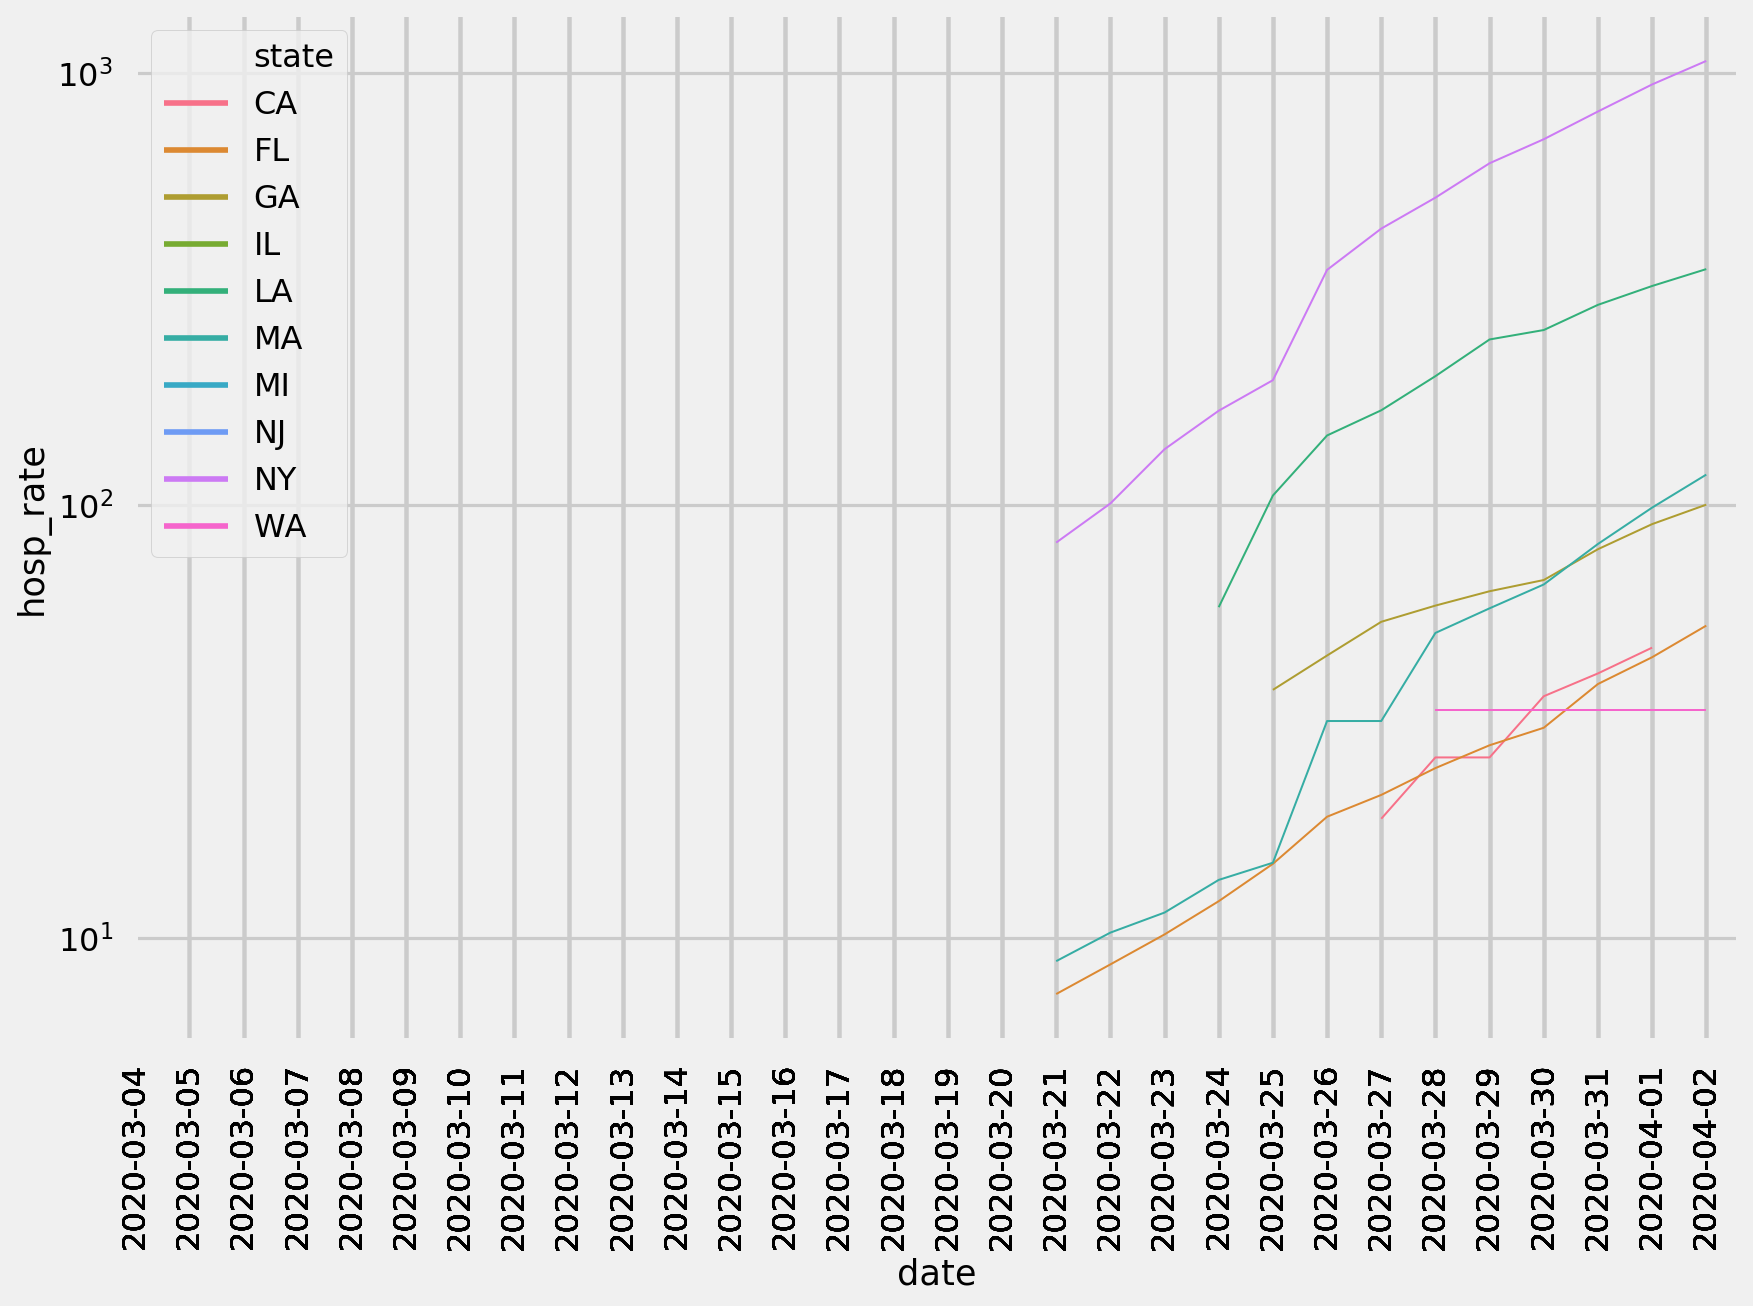

In [64]:
ax = sns.lineplot(x="date", y="hosp_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per Million People

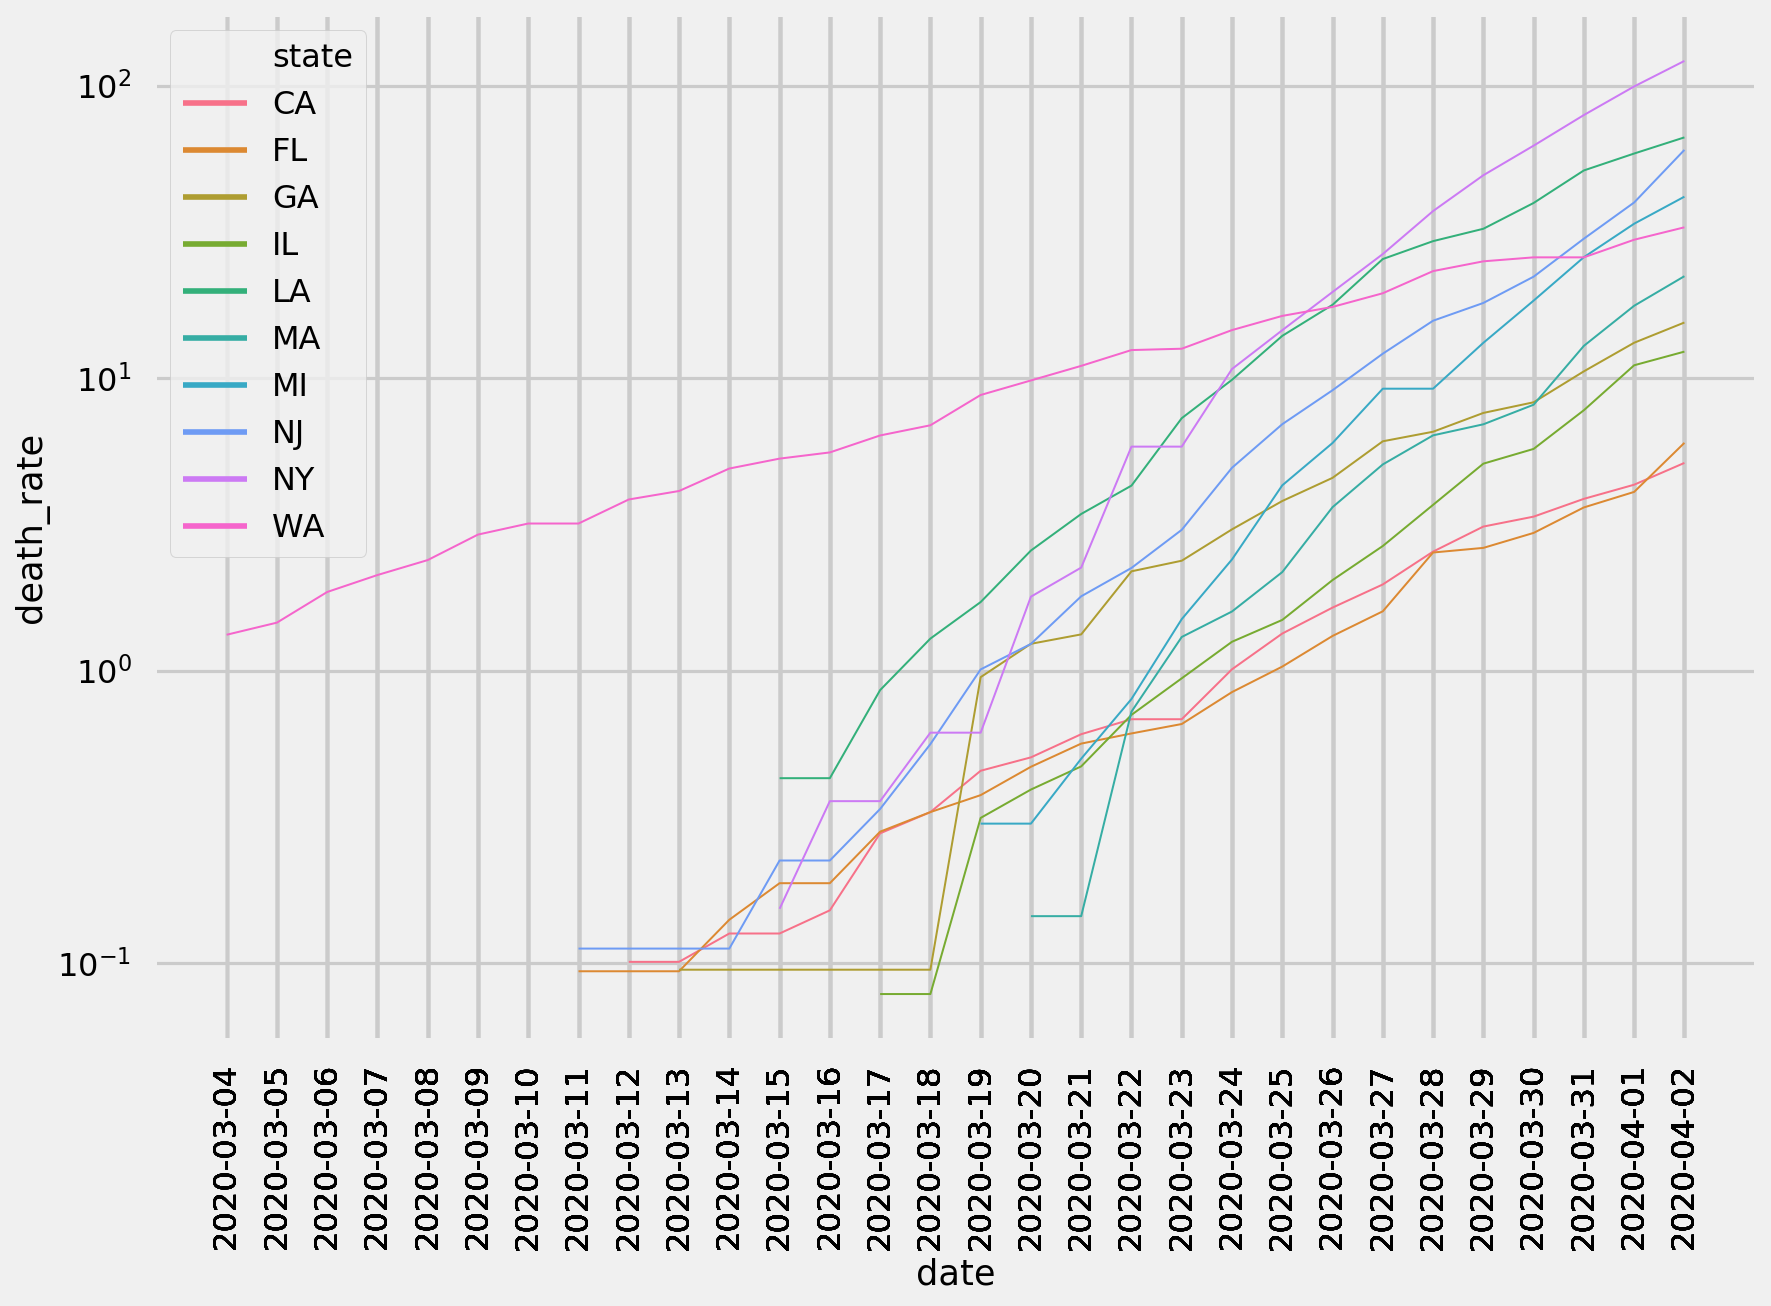

In [65]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per Million People

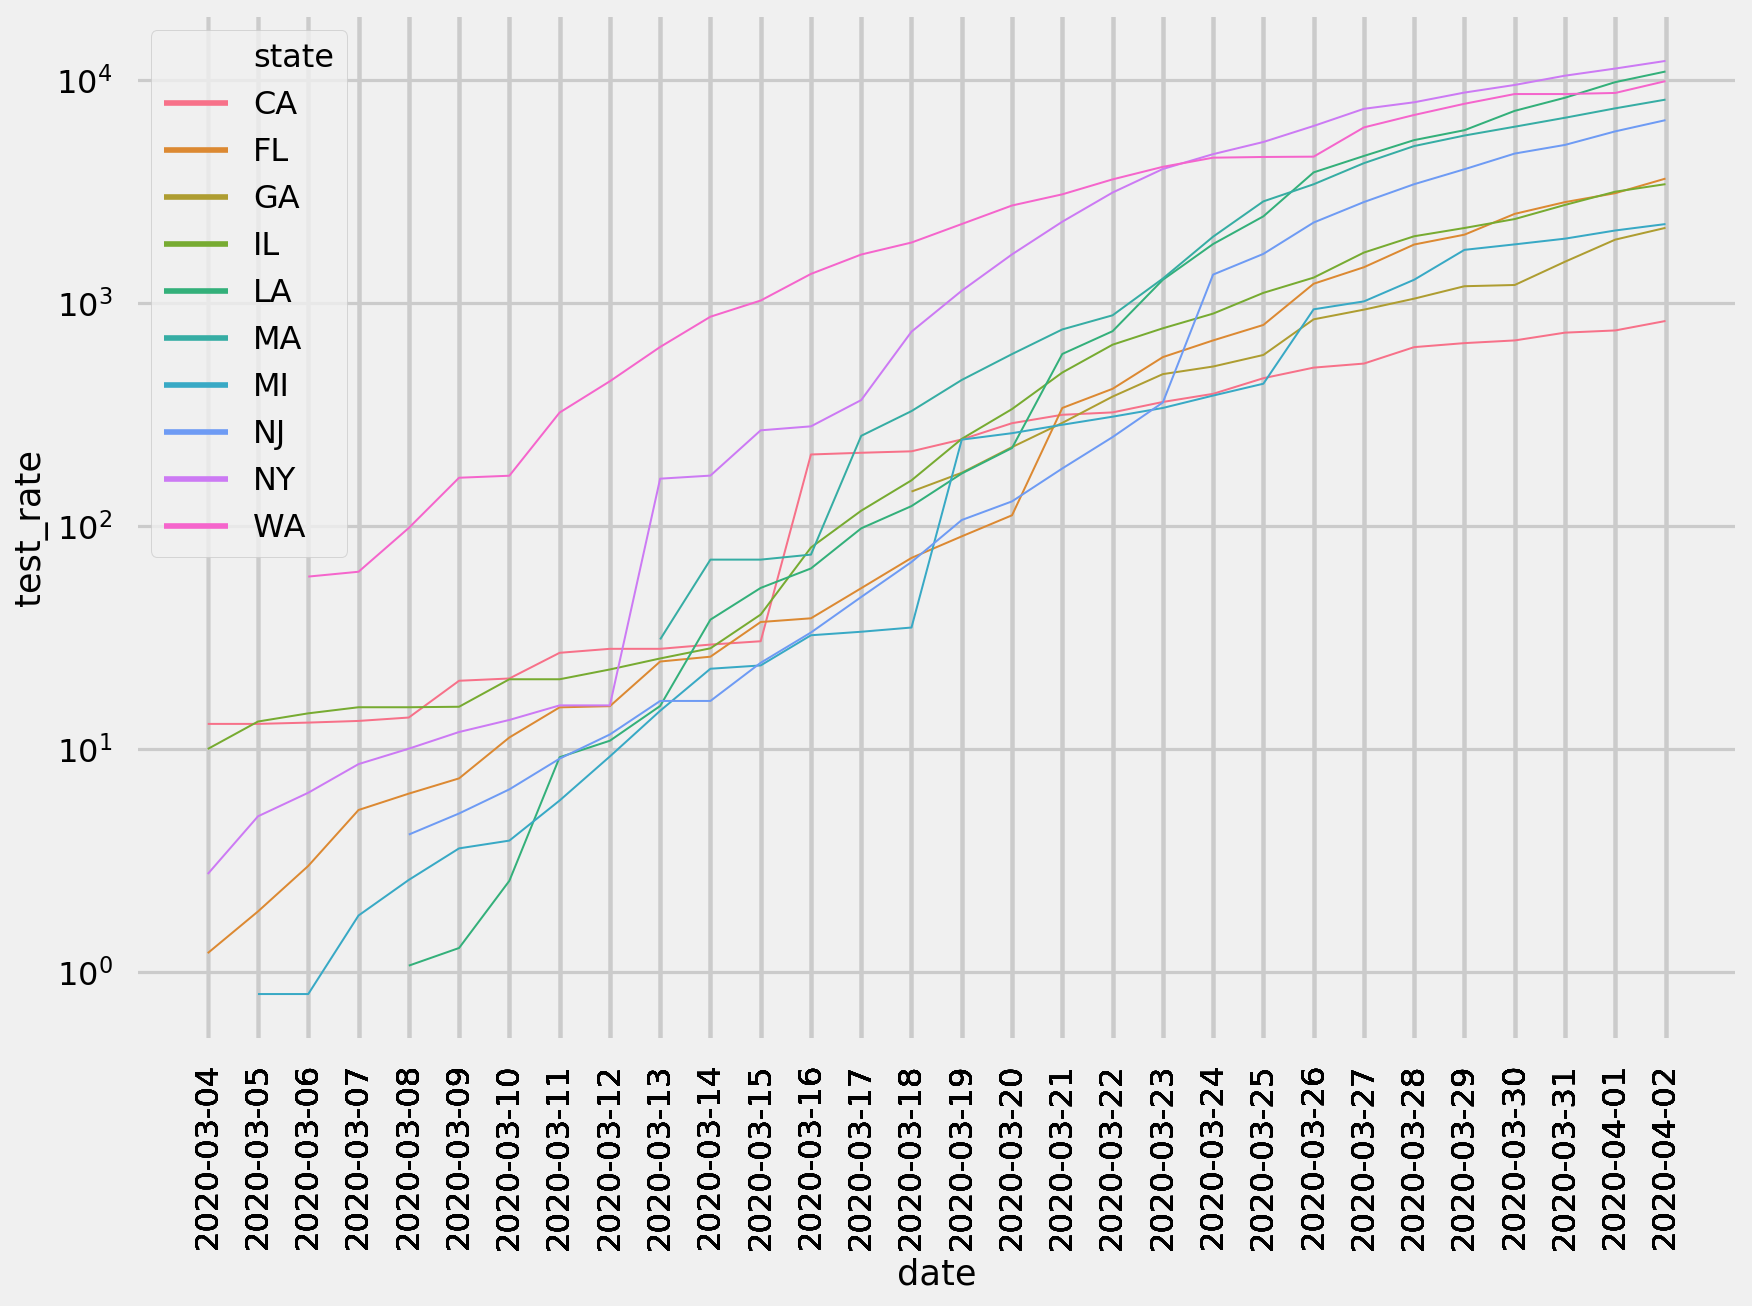

In [66]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [67]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
965,NY,12228.146777
512,LA,10962.712700
1354,WA,9925.963339
539,MA,8201.503619
1326,VT,8061.644678
316,HI,7366.466947
199,DC,7217.544184
0,AK,6810.064033
908,NM,6686.462145
1270,UT,6663.809016
